In [1]:
from collections import Counter

import torch
import matplotlib.pyplot as plt

from torch import nn
from torchvision.datasets import DatasetFolder
from torchaudio import load, pipelines, transforms
from torch.utils.data import random_split

from librosa import stft

/Users/wsrtk/miniforge3/envs/audio/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: Image data of dtype complex64 cannot be converted to float

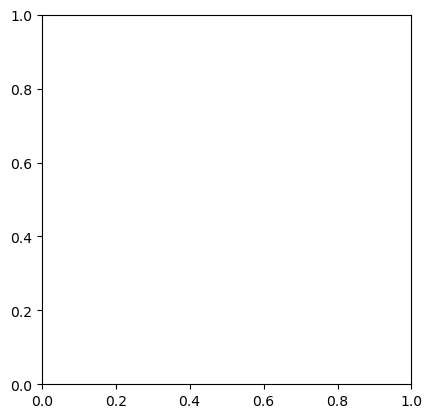

In [9]:
example = stft(df[0][0].numpy())
plt.imshow(example)
plt.show()

In [3]:
def loader(filepath):
    data = load(filepath)[0]
    data = torch.squeeze(data)
    return data

In [4]:
# set manual seed for reproducibility
torch.manual_seed(0)
# load data and check
df = DatasetFolder(
    "../data",
    loader=loader,
    extensions=("wav"),
    transform=transforms.Resample(44500, 16000),
)
print(dict(Counter(df.targets)))
print(len(df))
# split data into train and test
train, test = random_split(df, (0.8, 0.2))
print(len(train), len(test))

{0: 85, 1: 82, 2: 85, 3: 82, 4: 85}
419
336 83


In [ ]:
# creatae pipeline
# bundle = pipelines.WAV2VEC2_BASE
# bundle = pipelines.HUBERT_BASE
bundle = pipelines.WAV2VEC2_ASR_BASE_10M
# WAV2VEC2_ASR_BASE_10M
bundle.sample_rate

In [ ]:
df[0][0]

In [ ]:
max_len = 0
min_len = 80000
lens = []
for x, label in df:
    if len(x) > max_len:
        max_len = len(x)
    if len(x) < min_len:
        min_len = len(x)
    lens.append(len(x))
print(max_len, min_len)

In [ ]:
plt.hist(lens, bins=100)

In [ ]:
model = bundle.get_model()
# with torch.inference_mode():
#     features, _ = model.extract_features(df[0][0])
print(model)

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [ ]:
class NeedleNet(nn.Module):
    def __init__(self, bundle, num_labels=5):
        super(NeedleNet, self).__init__()
        self.num_labels = num_labels

        self.model = bundle.get_model()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, x):
        outputs = self.model(x)
        # outputs = torch.sum(outputs, axis=1)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs


class Average(nn.Module):
    def __init__(self, axis):
        super().__init__()
        self.axis = axis

    def forward(self, x):
        output = x.mean(dim=self.axis)
        output = torch.squeeze(output, -2)
        return output

In [ ]:
model = bundle.get_model()

In [ ]:
df[0][0]

In [ ]:
model.aux = nn.Sequential(Average(axis=-2), nn.Linear(768, 5))
model.train()
with torch.inference_mode():
    emission, _ = model(torch.unsqueeze(df[0][0], 0))
emission

In [ ]:
m = nn.AdaptiveAvgPool1d(1)
m(emission.transpose(-2, -1)).shape, m(emission).shape

In [ ]:
# plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [ ]:
model